In [543]:
#Imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Constants

In [17]:
class Constants:
    """
    Important Constants for Calculations
        c = Speed of light (m/s)

        Mu0 = permeability of free space in H/m

        MuB = Bohr magneton in J/T

        Epsilon0 = permittivity of free space in F/m

        amu = atomic mass unit in kg

        HBar = reduced planck's constant in Js

        kB = Stegan-Boltzman constant in J/K

        h = planck's constat in Js

        a0 = bohr radius in dm

        g = gravitational acceleration in m/s^2

        Lamdba1064 = 1064nm in m
    """

    #Constants
    c = 2.99792458e8
    Mu0 = 4*np.pi*1e-7
    MuB = 9.2740095e-24
    Epsilon0 = 8.854187e-12
    amu = 1.66053906892e-27
    HBar = 1.054571628e-34
    kB = 1.3806504e-23
    h = 6.62607015e-34
    a0 = 0.52917720859e-10
    g = 9.807 
    
    #Conversions
    Lambda1064 = 1064e-9
    Lambda632 = 632e-9


# Atomic Properties

In [535]:
class Cs133:
    """This class stores atomic properties of cesium-133."""
    mass = 132.905451931 * Constants.amu  # atomic mass in kg
    aBB = 277 # Cs-Cs scattering length in bohr radii

    class GS: #ground state
        g_j = 2.002540261 #fine structure landé g-factor
        aHF = Constants.h * 2.2981579425e9 #hyperfine structure constant in J

    class D1: #D1 Transition
        wavelength = 894.59295987e-9  # wavelength (in vaccum) in m
        Gamma = 2 * np.pi * 4.575e6  # decay rate in rad/s
    
    class D2: #D2 Transition
        wavelength = 852.34727582e-9  # wavelength (in vacuum) in m
        Gamma = 2 * np.pi * 5.234e6  # decay rate in rad/s


In [4]:
class Li6:
    """This class stores atomic properties of lithium-6."""
    mass = 6.0151214 * Constants.amu  # atomic mass in kg

    class GS: #ground state
        g_j = 2.0023010 #Total electronic g-factor 
        aHF = Constants.h * 152.1368407e6 # hyperfine structure constrant in J

    class D1: #D1 transition
        wavelength = 670.992421e-9 # wavelength in m
        Gamma = 2 * np.pi * 5.8724e6 # decay rate in rad/s
    
    class D2: #D2 transition
        wavelength = 670.992421e-9 # wavelength in m
        Gamma = 2 * np.pi * 5.8724e6 # decay rate in rad/s


# Electric Field Intensity

### Formula

The formulas for field intensity comes from [this link](https://www.rp-photonics.com/gaussian_beams.html). The general expression for the intensity of a gaussian electric field propagating in the x direction is:
$$ I(r,x) = \frac{P}{\pi \omega(x)^2 /2} e^{-2 \frac{r^2}{\omega(x)^2}}$$

where:
- P is the beam power in watts
- $\omega(x)$ is the beam waist

If we assume that the beam waist can be split into the waist in the y direction and the waist in the z direction, then the intensity can be rewritten as:
$$ I(y,z) = \frac{P}{\pi \omega_y \omega_z / 2} e^{-2 \frac{y^2}{\omega_y^2}} e^{-2 \frac{z^2}{\omega_z^2}} $$

Where $\omega_y$ and $\omega_z$ are the beam waists in y and z respectively

### Code

In [6]:
def field_intensity(y,z, *args):
    """
    Function for computing the beam intensity of a gaussian laster beam

    args:
        y: y-position (in  microns)
        z: z-position (in microns)
        args: (power in W, beam waist in the y direction in m, beam waist in the z direction in m)
    
    returns: Laser Intensity in (W/m^2)
    """

    #get parameters
    args = args[0]
    
    power = args[0]
    bw_y = args[1]
    bw_z = args[1]

    #convert distances to m
    y = y*1e-6
    z = z*1e-6

    #compute the field instensity
    coef = power/ (np.pi * bw_y * bw_z / 2)
    
    return coef * np.exp(-2 * y**2 / bw_y**2) * np.exp(-2 * z**2 / bw_z**2)

If we graph it

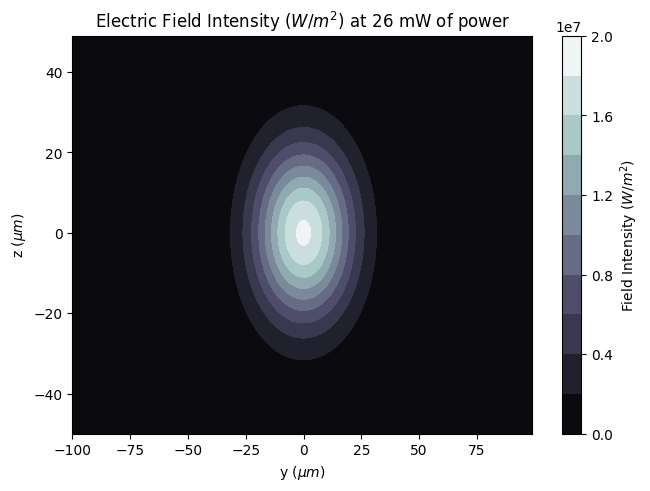

In [139]:
def graph_intensity(field_params):
    y = np.arange(-100, 100)
    z = np.arange(-50, 50)

    Y, Z = np.meshgrid(y, z)
    intensity = field_intensity(Y,Z, field_params)

    fig1, ax2 = plt.subplots(layout = 'constrained')

    CS = ax2.contourf(Y, Z, intensity, 10, cmap=plt.cm.bone)

    ax2.set_title(r'Electric Field Intensity ($W/m^2$) at 26 mW of power')
    ax2.set_xlabel(r"y ($\mu m$)")
    ax2.set_ylabel(r"z ($\mu m$)")

    #add color bar
    cbar = fig1.colorbar(CS)
    cbar.ax.set_ylabel(r"Field Intensity ($W/m^2$)")

field_args = (26e-3, 30e-6, 30e-6)
graph_intensity(field_args)

plt.show()

# The Potential

## Dipole Potential

### Formula

The general expression for the dipole potential comes from page 6 of [this paper](https://www.uni-ulm.de/fileadmin/website_uni_ulm/nawi.inst.220/lehre/Atomphysik_SS2008/9902072v1.pdf) and is of the form
$$ U_{dip} = \frac{\pi c^2 \Gamma}{2\omega_0^2} \left( \frac{2 + Pg_F m_F}{\Delta_{2,F}} + \frac{1 - Pg_F m_F}{\Delta_{1,F}} \right) I(\vec{r})$$

Where:
- $\Gamma$ is the decay rate of the excited state in rad/s
- $\omega_0$ is the resonant frequency of the transition in m
- $P$ is a coefficient which characterizes the polarization
    - $P = 0$ for linear polarization
    - $P = \pm 1$ for circular polarization

- $g_F$ is the landé g-factor
- $m_F$ is the magnetic quantum number
- $\Delta_{i_f} = \omega - \omega_0$ is the frequency detuning for the D1 or D2 transition
- $I(\vec{r})$ is the intensity as a function of position

For this calculation we will be dealing with linealy polarized light and a laser beam propagating in the x-direction so the expression reduces to:
$$ U_{dip} = \frac{\pi c^2 \Gamma}{2\omega_0^3} \left( \frac{2}{\Delta_{2,F}} + \frac{1}{\Delta_{1,F}} \right) I(y,z)$$

### Code

In [ ]:
def dipole_potential(y,z, *args):
    """
    Function for computing electric dipole potential

    inputs:
        y: y-position in microns
        z: z-position in microns
        args: tuple
            - gamma: D2 decay rate in rad/s
            - lambda_laser: laser wavelength in m
            - lambda_D1: D1 transition frequency in m
            - lambda_D2: D1 transition frequenct in m
            - intensity_args: parameters for field_intensity (see above)
    
    returns: Dipole potential in (Hz) (we just divided the potential by hbar)
    """
    #get parameters
    args=args[0]
    gamma = args[0]

    lambda_laser = args[1]
    lambda_D1 = args[2]
    lambda_D2 = args[3]

    intensity_args = args[4]

    omega = 2*np.pi*Constants.c / lambda_laser
    omega01 = 2*np.pi*Constants.c / lambda_D1
    omega02 = 2*np.pi*Constants.c / lambda_D2

    delta1 = omega - omega01
    delta2 = omega - omega02

    coef = (np.pi * Constants.c**2 * gamma)/(2 * omega02**3)

    intensity = field_intensity(y,z, intensity_args)

    return (coef * (2/delta2 + 1/delta1) * intensity) / Constants.h

We can try to graph this for Cs133 and Li6 Illuminated by a 632 nm laser at 26 mW to get a look at what the dipole potential should look like for the experiment

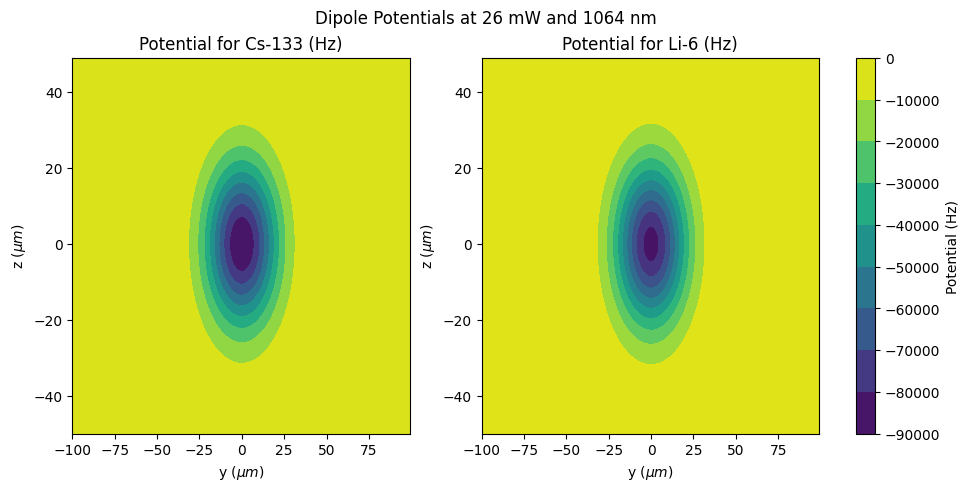

In [123]:
def graph_dipole_potential():
    #laser parameters
    field_args = (26e-3, 30e-6, 30e-6)

    #Cesium 133 parameters
    gamma_cs = Cs133.D2.Gamma
    lambda_laser_cs = Constants.Lambda1064
    lambda_D1_cs = Cs133.D1.wavelength
    lambda_D2_cs = Cs133.D2.wavelength

    cs_dipole_potential_args = (gamma_cs, lambda_laser_cs, lambda_D1_cs, lambda_D2_cs, field_args)

    #Lithium 6 parameters
    gamma_li = Li6.D2.Gamma
    lambda_laser_li = Constants.Lambda1064
    lambda_D1_li = Li6.D1.wavelength
    lambda_D2_li = Li6.D2.wavelength

    li_dipole_potential_args = (gamma_li, lambda_laser_li, lambda_D1_li, lambda_D2_li, field_args)

    #generate coordinates and figure
    y = np.arange(-100, 100)
    z = np.arange(-50, 50)
    Y, Z = np.meshgrid(y, z)

    fig, ax = plt.subplots(1,2, layout = 'constrained', figsize=plt.figaspect(0.5))
    fig.suptitle("Dipole Potentials at 26 mW and 1064 nm")

    #get dipole potentials
    cs_dip_potential = dipole_potential(Y,Z, cs_dipole_potential_args)
    li_dip_potential = dipole_potential(Y,Z, li_dipole_potential_args)

    #plot cesium potential
    CS = ax[0].contourf(Y, Z, cs_dip_potential, 10, cmap=plt.cm.viridis)
    ax[0].set_title('Potential for Cs-133 (Hz)')
    ax[0].set_xlabel(r"y ($\mu m$)")
    ax[0].set_ylabel(r"z ($\mu m$)")

    #plot Lithium potential
    LI = ax[1].contourf(Y, Z, li_dip_potential, 10, cmap=plt.cm.viridis)
    ax[1].set_title('Potential for Li-6 (Hz)')
    ax[1].set_xlabel(r"y ($\mu m$)")
    ax[1].set_ylabel(r"z ($\mu m$)")

    #add color bar
    cbar = fig.colorbar(CS, ax=ax.ravel().tolist())
    cbar.ax.set_ylabel("Potential (Hz)")

graph_dipole_potential()
plt.show()

## Magnetic Potential

### Formula

The Bitter coils used in the experiment will also contribute to the total potential experienced by the atoms. Here we assume that the atoms will be at the maximum of the field and that the field itself will be cylindrically symmetric about the z axis due to the orientation of the coils. The magnetic field will approximately be of the form:
$$ B = -\omega_B (x^2 + y^2) + 2\omega_B z^2 $$

Where $\omega_B = 2 \times 10^5$ is the approximate frequency of the magnetic trap used in the experiment

From this, the magnetic potential will be:
$$ U_B = -\frac{\mu_B g_J}{2} \frac{B}{10000} $$

### Code

In [ ]:
def magnetic_field(x,y,z):
    """
    Function for calculating the magnetic field intenstity

    inputs:
        x,y,z: position in microns
    
    returns: Magnetic field strength in Gauss
    """
    omegaB = 2e5

    #convert units to meters
    x = x*1e-6
    y = y*1e-6
    z = z*1e-6

    return -omegaB * (x**2 + y**2) + 2*omegaB * z**2

In [528]:
def magnetic_potential(x,y,z, *args):
    """
    Function for calculating the magnetic field potential for an atom

    inputs:
        - x,y,z: position in microns
        - args:
            - g_j: landé g-factor
    
    returns: Magnetic field potential in Hz (we just divide the potential by hbar)
    """
    g_j = args[0]

    coef = (Constants.MuB * g_j)/2

    B = magnetic_field(x,y,z)

    return - (coef * B / (1e4)) / Constants.h

If we graph it for cesium 133 and Li 6

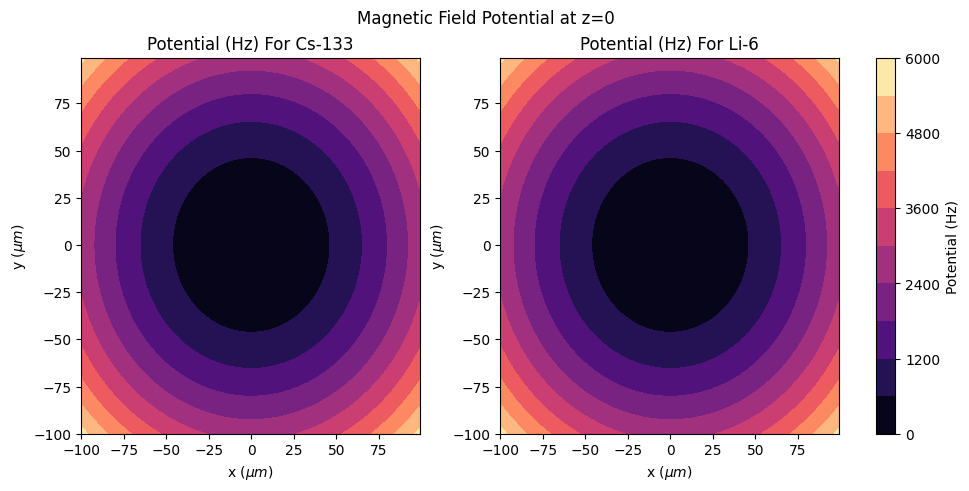

In [510]:
def graph_b_potential():
    #magnetic field parameters
    cs_b_potential_args = (Cs133.GS.g_j)
    li_b_potential_args = (Li6.GS.g_j)

    atom_height = 0 #where the atoms should be

    #generate coordinates and figure
    x = np.arange(-100, 100)
    y = np.arange(-100, 100)
    X, Y = np.meshgrid(x,y)

    fig, ax = plt.subplots(1,2, layout = 'constrained', figsize=plt.figaspect(0.5))
    fig.suptitle("Magnetic Field Potential at z=0")

    #Get potentials
    cs_b_potential = magnetic_potential(X,Y,atom_height, cs_b_potential_args)
    li_b_potential = magnetic_potential(X,Y,atom_height, li_b_potential_args)

    #plot Cesium magnetic potential
    CS = ax[0].contourf(X, Y, cs_b_potential, 10, cmap=plt.cm.magma)

    ax[0].set_title('Potential (Hz) For Cs-133')
    ax[0].set_xlabel(r"x ($\mu m$)")
    ax[0].set_ylabel(r"y ($\mu m$)")

    #plot Lithium magnetic potential
    LI = ax[1].contourf(X, Y, li_b_potential, 10, cmap=plt.cm.magma)

    ax[1].set_title('Potential (Hz) For Li-6')
    ax[1].set_xlabel(r"x ($\mu m$)")
    ax[1].set_ylabel(r"y ($\mu m$)")

    #add color bar
    cbar = fig.colorbar(CS, ax=ax.ravel().tolist())
    cbar.ax.set_ylabel("Potential (Hz)")

graph_b_potential()
plt.show()

## Gravitational Potential

The gravitational potential is given by the simple formula:
$$ U_{grav} = mgz $$

In [507]:
def grav_potential(z, *args):
    """
    Function for computing the gravitational potential energy of an atom

    inputs:
        - z: height in microns
        - args:
            - m: mass in kg
    
    returns: gravitational potential in Hz (we just divide the potential by hbar)
    """
    m = args[0]
    z = z * 1e-6

    return (m * Constants.g * z) / Constants.h

We can graph this for cesium

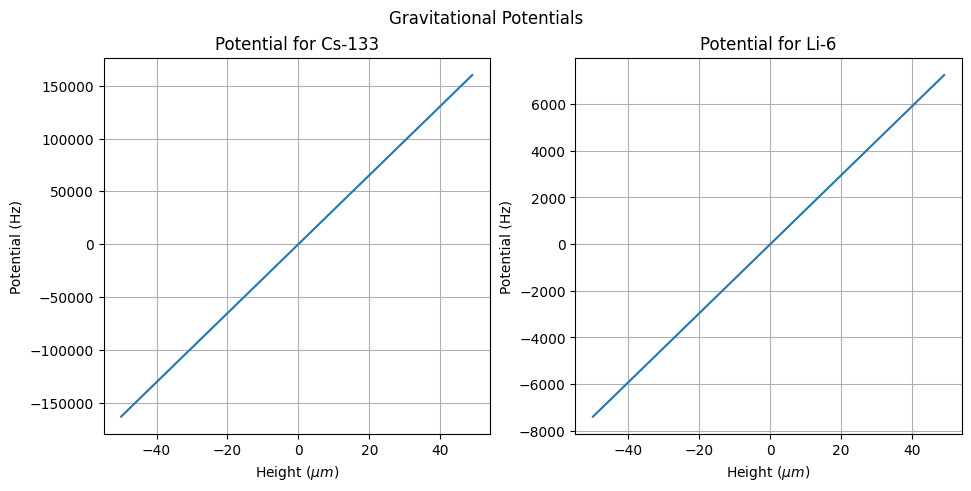

In [511]:
def graph_grav_potential():
    z = np.arange(-50,50)
    fig, ax = plt.subplots(1,2, layout="constrained", figsize=plt.figaspect(0.5))
    fig.suptitle("Gravitational Potentials")

    ax[0].plot(z, grav_potential(z, (Cs133.mass)))
    ax[1].plot(z, grav_potential(z, (Li6.mass)))

    ax[0].set_title("Potential for Cs-133")
    ax[0].set_xlabel(r"Height ($\mu m$)")
    ax[0].set_ylabel("Potential (Hz)")
    ax[0].grid(True)

    ax[1].set_title("Potential for Li-6")
    ax[1].set_xlabel(r"Height ($\mu m$)")
    ax[1].set_ylabel("Potential (Hz)")
    ax[1].grid(True)

graph_grav_potential()
plt.show()

## Total Potential

The total potential will just be the sum of the above three potentials:
$$ U_{tot} = U_{dip} + U_B + U_{grav}  $$

In [ ]:
def total_potential(r, *args):
    """
    Function for computing the total potential experienced by an atom

    inputs:
        - x,y,z: position in microns
        - args:
            - dipole_params: parameters for dipole potential (see dipole_potential)
            - b_params: parameters for the magnetic field (see magnetic_potential)
            - grav_params: parameters for gravitational potential (see grav_potential)
    
    returns (float): The total potential in Hz
    """
    params = args[0]
    dipole_params = params[0]
    b_params = params[1]
    grav_params = params[2]

    #get x,y,z
    x = r[0]
    y = r[1]
    z = r[2]

    u_dip = dipole_potential(y,z, dipole_params)

    u_b = magnetic_potential(x,y,z, b_params)
    u_grav = grav_potential(z, grav_params)

    return u_dip + u_b + u_grav

The total potential in the z direction will look like:

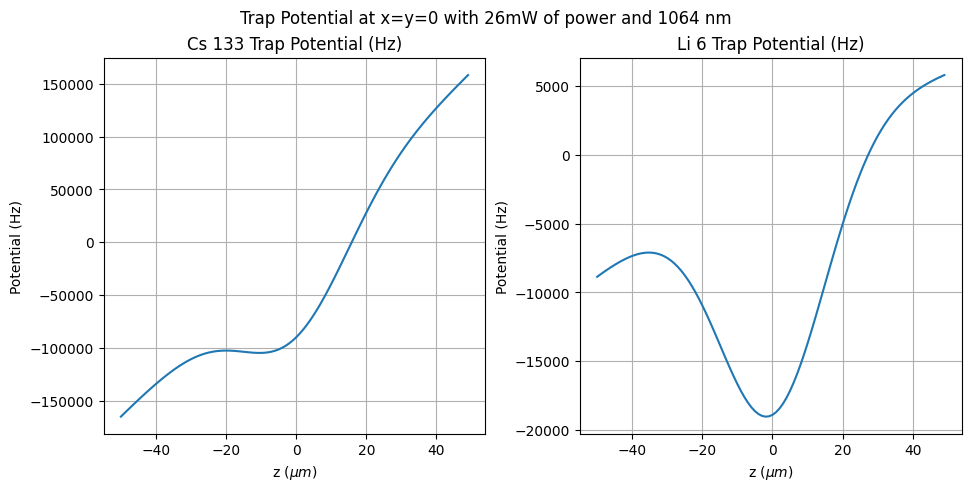

In [548]:
def graph_total_potential():
    #electric field parameters
    field_args = (26e-3, 30e-6, 30e-6)

    #Cesium 133 parameters
    gamma_cs = Cs133.D2.Gamma
    lambda_laser_cs = Constants.Lambda1064
    lambda_D1_cs = Cs133.D1.wavelength
    lambda_D2_cs = Cs133.D2.wavelength

    cs_dipole_potential_params = (gamma_cs, lambda_laser_cs, lambda_D1_cs, lambda_D2_cs, field_args)
    cs_b_potential_params = (Cs133.GS.g_j)
    cs_grav_potential_params = (Cs133.mass)

    #Lithium 6 parameters
    gamma_li = Li6.D2.Gamma
    lambda_laser_li = Constants.Lambda1064
    lambda_D1_li = Li6.D1.wavelength
    lambda_D2_li = Li6.D2.wavelength

    li_dipole_potential_params = (gamma_li, lambda_laser_li, lambda_D1_li, lambda_D2_li, field_args)
    li_b_potential_params = (Li6.GS.g_j)
    li_grav_potential_params = (Li6.mass)

    #trap potential params
    cs_trap_params = (cs_dipole_potential_params, cs_b_potential_params, cs_grav_potential_params)
    li_trap_params = (li_dipole_potential_params, li_b_potential_params, li_grav_potential_params)

    #generate coordinates and figure
    x = np.arange(-100, 100)
    y = np.arange(-100, 100)
    z = np.arange(-50,50)

    fig = plt.figure(layout = 'constrained', figsize=plt.figaspect(0.5))
    fig.suptitle("Trap Potential at x=y=0 with 26mW of power and 1064 nm")

    #get total potentials
    cs_potential = total_potential([0,0,z], cs_trap_params)
    li_potential = total_potential([0,0,z], li_trap_params)

    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(z, cs_potential)
    ax1.set(xlabel=r'z ($\mu m$)', ylabel=r'Potential (Hz)', title="Cs 133 Trap Potential (Hz)")
    ax1.grid(True)

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(z, li_potential)
    ax2.set(xlabel=r'z ($\mu m$)', ylabel=r'Potential (Hz)', title="Li 6 Trap Potential (Hz)")
    ax2.grid(True)

graph_total_potential()
plt.show()

# Trap Calculations

Trap Parameters:

In [529]:
#electric field parameters
field_args = (26e-3, 30e-6, 30e-6)


#Cesium 133 parameters
gamma_cs = Cs133.D2.Gamma
lambda_laser_cs = Constants.Lambda1064
lambda_D1_cs = Cs133.D1.wavelength
lambda_D2_cs = Cs133.D2.wavelength

cs_dipole_potential_params = (gamma_cs, lambda_laser_cs, lambda_D1_cs, lambda_D2_cs, field_args)
cs_b_potential_params = (Cs133.GS.g_j)
cs_grav_potential_params = (Cs133.mass)

cs_trap_params = (cs_dipole_potential_params, cs_b_potential_params, cs_grav_potential_params)


#Lithium 6 parameters
gamma_li = Li6.D2.Gamma
lambda_laser_li = Constants.Lambda1064
lambda_D1_li = Li6.D1.wavelength
lambda_D2_li = Li6.D2.wavelength

li_dipole_potential_params = (gamma_li, lambda_laser_li, lambda_D1_li, lambda_D2_li, field_args)
li_b_potential_params = (Li6.GS.g_j)
li_grav_potential_params = (Li6.mass)

li_trap_params = (li_dipole_potential_params, li_b_potential_params, li_grav_potential_params)



## Trap Depth

The trap depth is just the difference between the minimum and the maximum of the potential

In [530]:
#first to find the minimum
cs_min_res = sp.optimize.minimize(total_potential, x0=[0,0,0], args=(cs_trap_params,))
li_min_res = sp.optimize.minimize(total_potential, x0=[0,0,0], args=(li_trap_params,))

cs_min = cs_min_res['fun']
cs_min_pos = cs_min_res['x']

li_min = li_min_res['fun']
li_min_pos = li_min_res['x']

#to find the maximum
inv = lambda r, arg: -total_potential(r,arg) #we just maximize the negative of the function

cs_max_res = sp.optimize.minimize(inv, x0=[0, 0,-20], args=(cs_trap_params,)) #we need to shift the z_0 to account to get the function to roll down the correct side of the hill
li_max_res = sp.optimize.minimize(inv, x0=[0, 0,-20], args=(li_trap_params,))

cs_max = -cs_max_res['fun'] #negative sign accounts for sign flip from lambda function
cs_max_pos = cs_max_res['x']

li_max = -li_max_res['fun']
li_max_pos = li_max_res['x']

#the trap depth is just the difference between the min and max frequencies
cs_trap_depth = cs_max - cs_min
li_trap_depth = li_max - li_min

print(f"The Cesium trap depth is {round(cs_trap_depth,3)} Hz")
print(f"The Lithium trap depth is {round(li_trap_depth,3)} Hz")

The Cesium trap depth is 2224.442 Hz
The Lithium trap depth is 11937.302 Hz


## Trap Frequency

Near the bottom of the trap, the potential can be treated as a harmonic potential of the form:
$$ V(\vec{r}) = \frac{1}{2} m \vec{\omega}^2 \vec{r}^2$$

Where $\vec{\omega}$ is the trap frequency. Therefore, if:
$$U_{dip}(\vec{r}) =  V(\vec{r})$$

Then we can find the trap frequency by just taking the laplacian of both sides which leaves:
$$\nabla^2 U_{dip}(\vec{r}) = m \vec{\omega}^2$$

The trap frequency is just:

$$\vec{\omega} = \sqrt{\frac{\nabla^2 U_{dip}(\vec{r_{bottom}})}{m} }$$

We evaluate this at the bottom of the trap since that's where the approximation works best

First we need to develop a function for computing the second derivatives in each direction, we'll do this by using the central finite difference method for computing second derivatives (see chapra and canale chapter 23?)

In [531]:
def partial_second_derivative(fun, r:list, dir:str, h:float, params:tuple):
    """
    Function for computing the second partial derivative of the potential with respect to a given direction using the central finite difference method

    inputs:
        fun (function): the input function
        r (list): position x,y, and z 
        dir (string): direction, must be x, y, or z
        h (float): step size for differentiation (smaller is better)
        params (tuple): parameters for the trap
    
    returns (float): the partial 2nd derivative at the given point 
     
    """
    deriv = None

    if dir == "x":
        x = r[0]
        x1 = x + 2*h
        x2 = x + h
        x3 = x - h
        x4 = x - 2*h

        y = r[1]
        z = r[2]

        r1 = [x1, y, z]
        r2 = [x2, y, z]
        r3 = [x3, y, z]
        r4 = [x4, y, z]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    if dir == "y":
        x = r[0]

        y = r[1]
        y1 = y + 2*h
        y2 = y + h
        y3 = y - h
        y4 = y - 2*h

        z = r[2]

        r1 = [x, y1, z]
        r2 = [x, y2, z]
        r3 = [x, y3, z]
        r4 = [x, y4, z]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    if dir == "z":
        x = r[0]
        y = r[1]

        z = r[2]
        z1 = z + 2*h
        z2 = z + h
        z3 = z - h
        z4 = z - 2*h

        r1 = [x, y, z1]
        r2 = [x, y, z2]
        r3 = [x, y, z3]
        r4 = [x, y, z4]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    return deriv


In [536]:
def compute_trap_frequency(potential_fun, trap_params, trap_bottom, mass):
    """
    Function for computing trap frequencies

    Inputs:
        potential_func: function for computing the potential
        trap_params: relevant trap parameters
        trap_bottom: location of the potential minimum (in micro meters)
        mass: atomic mass in kg

    returns: trap frequency: frequency values in x, y, and z in Hz

    """
    h1 = 1

    #compute the value of second derivatives in each direction at the trap bottom using both step sizes
    d2udx2 = partial_second_derivative(fun=potential_fun, r=trap_bottom, dir='x', h=h1, params=trap_params)
    d2udy2 = partial_second_derivative(fun=potential_fun, r=trap_bottom, dir='y', h=h1, params=trap_params)
    d2udz2 = partial_second_derivative(fun=potential_fun, r=trap_bottom, dir='z', h=h1, params=trap_params)

    #compute the trap frequency in each direction
    fx = np.sqrt( (d2udx2 * Constants.h) / mass ) / (2 * np.pi) * 1e6
    fy = np.sqrt( (d2udy2 * Constants.h) / mass ) / (2 * np.pi) * 1e6
    fz = np.sqrt( (d2udz2 * Constants.h) / mass ) / (2 * np.pi) * 1e6

    return [fx, fy, fz]

compute_trap_frequency(total_potential, cs_trap_params, cs_min_pos, Cs133.mass)

[np.float64(6.529254221811657),
 np.float64(154.53416052126752),
 np.float64(110.29513167300198)]

## BEC Calculations

The code here is just copied over from [LiCs-Codebase v2](https://github.com/ChinlabLiCsCode/LiCs-CodebaseV2)

In [544]:
class BEC_calc():
    """
    Class for computing various quantities related to a Cs133 BEC

    Parameters:
        fx: frequency in the x direction (Hz)
        fy: frequency in the y direction (Hz)
        fz: frequency in the z direction (Hz)
        N: the number of atoms?
        a: scattering length (bohr radii)
    
    Returns:
        a_ho: Harmonic Oscillator length (microns)
        muT: chemical potential (nK) #convert to temp by dividing by k_b
        pD: peakDensity
        R_tf: Thomas-Fermi Radii: (Rx, Ry, Rz) (meters)
        xi: Central healing Length (microns)
        TCrit: critical temperature (nK)
        TCor: correction to critical temperature (fraction) caused by finite size and non uniformity
        aCrit: critical scattering length for a spherical potential (m)
        vSound: sound speed (mm/s)
        lambdaDB: Wrong? deBroglie wavelength (microns)
        phaseDensity: Wrong? phase space density # find the formula
    """
    def __init__(self,fx, fy, fz, N, a, printRes:bool):
        self.fx=fx
        self.fy=fy
        self.fz=fz
        self.N=N
        self.a=a

        #create a dictionary to store all of the rounded results, if you use the functions, you'll get the exact result
        self.results = dict()

        #convert scattering length to meters
        self.aBr = a *Constants.a0

        #convert frequencies to angluar frequencies
        self.wx = 2*np.pi*fx
        self.wy = 2*np.pi*fy
        self.wz = 2*np.pi*fz

        #compute intermediate values such as the cesium interaction strength, average frequency, and geometric average frequencies
        self.gInt = 4*np.pi*(Constants.HBar**2)*self.aBr / Cs133.mass

        self.w_ho = (self.wx*self.wy*self.wz)**(1/3)

        self.wAvg = np.mean([self.wx, self.wy, self.wz])

        #run all of the calculation functions
        self.a_hoCalc(printVal=False)
        self.muTCalc(printVal=False)
        self.pDCalc(printVal=False)
        self.tfCalc(printVal=False)
        self.xiCalc(printVal=False)
        self.ctCalc(printVal=False)
        self.aCritCalc(printVal=False)
        self.vCalc(printVal=False)
        self.lambdaCalc(printVal=False)
        self.phaseDensityCalc(printVal=False)

        if printRes:
            self.genRes()

    def a_hoCalc(self, printVal:bool):
        "function for computing the harmonic oscillator length, returns value in microns"
        self.a_ho = np.sqrt(Constants.HBar/(Cs133.mass*self.w_ho))
        self.results["Harmonic Oscillator Length (microns)"] = round(self.a_ho * 1e6, 5)

        if printVal:
            return self.a_ho * 1e6

    def muTCalc(self, printVal:bool):
        "function for computing the chemical potential, returns value in nK"
        self.mu = (Constants.HBar*self.w_ho/2)*(15*self.N*self.aBr/self.a_ho)**(2/5)
        self.muT = self.mu / Constants.kB * 1e9 #chemical potential in nK
        self.results["chemical Potential (nK)"] = round(self.muT, 5)

        if printVal:
            return self.muT

    def pDCalc(self, printVal:bool):
        "function for computing peak density"
        self.pD = self.mu/self.gInt
        self.results["Peak Density"] = round(self.pD, 5)

        if printVal:
            return self.pD

    def tfCalc(self, printVal:bool):
        "function for computing the thomas-fermi radius, returns the result in meters"
        rx = np.sqrt( 2*self.mu / (Cs133.mass * (self.wx**2)) )
        ry = np.sqrt( 2*self.mu / (Cs133.mass * (self.wy**2)) )
        rz = np.sqrt( 2*self.mu / (Cs133.mass * (self.wz**2)) )

        R_tf = np.array([rx, ry, rz])
        approxR_tf = np.array([round(rx, 10), round(ry, 10), round(rz, 10)])

        self.results["Thomas-Fermi Radius (m)"] = approxR_tf

        if printVal:
            return R_tf

    def xiCalc(self, printVal:bool):
        "function for computing the central healing length, returns the result in microns"
        xi = (8*np.pi*(self.mu/self.gInt)*self.aBr)**(-1/2)
        self.results["Central healing Length (microns)"] = round(xi*1e6, 5)

        if printVal:
            return xi*1e6

    def ctCalc(self, printVal:bool):
        "function for computing the critical temperature and the corrections, returns the result as an array with the critical temperature (nK), and the total correction as a fraction"
        self.TCrit = 0.94 * Constants.HBar * self.w_ho * self.N**(1/3) / Constants.kB
        self.results["Critical Temperature (nK)"] = round(self.TCrit * 1e9, 5)

        #compute the corrections to the critical temperature
        dT_fsOverTCrit = -0.73 * (self.wAvg/self.w_ho) * self.N**(-1/3) #finite size correction
        dT_ihOverTCrit  = -1.33 * (self.aBr/self.a_ho) * self.N**(1/6) #inhomogenous correction
        TCor = dT_fsOverTCrit + dT_ihOverTCrit
        self.results["Critical Temperature Correction (%)"] = round(TCor, 5)

        if printVal:
            return np.array([self.TCrit*1e9, TCor])

    def aCritCalc(self, printVal:bool):
        "function for computing the critical scattering length, returns the result in meters"
        aCrit = 0.575 * self.a_ho / self.N / Constants.a0
        self.results["Critical Scattering Length (m)"] = round(aCrit, 5)

        if printVal:
            return aCrit

    def vCalc(self, printVal:bool):
        "function for computing the sound speed, returns the result in mm/s"
        vSound = np.sqrt(self.mu/Cs133.mass)
        self.results["sound speed (mm/s)"] = round(vSound *1e3, 5)

        if printVal:
            return vSound*1e3

    def lambdaCalc(self, printVal:bool):
        "function for computing the deBroglie wavelength, returns the result in microns"
        self.lambdaDB = np.sqrt( (2*np.pi*Constants.HBar**2)/(Cs133.mass*self.mu) )
        self.results["deBroglie Wavelength (microns)"] = round(self.lambdaDB * 1e6, 5)

        if printVal:
            return self.lambdaDB * 1e6

    def phaseDensityCalc(self, printVal:bool):
        "function for computing the peak phase space density"
        phaseDensity = self.lambdaDB**3 * (self.mu/self.gInt)
        self.results["Phase space density"] = round(phaseDensity, 5)

        if printVal:
            return phaseDensity

    def genRes(self):
        "Generates results as a pandas data table"
        params = []
        vals = []

        #sort each parameter and value into lists
        for key in self.results:
            params.append(key)
            vals.append(self.results[key])

        #create the dataframe
        df = pd.DataFrame.from_dict({
            "parameter": params,
            "Values":vals
        })

        #display the dataframe
        display(df)

fx, fy, fz = compute_trap_frequency(total_potential, cs_trap_params, cs_min_pos, Cs133.mass)
NCs = 2e4

calc = BEC_calc(fx=fx,fy=fy,fz=fz,N=NCs,a=Cs133.aBB,printRes=True)

,parameter,Values
0,Harmonic Oscillator Length (microns),1.25741
1,chemical Potential (nK),30.18422
2,Peak Density,44896520661872885760.0
3,Thomas-Fermi Radius (m),"[4.73704e-05, 2.0015e-06, 2.8042e-06]"
4,Central healing Length (microns),0.24589
5,Critical Temperature (nK),58.9013
6,Critical Temperature Correction (%),-0.13135
7,Critical Scattering Length (m),0.68315
8,sound speed (mm/s),1.37416
9,deBroglie Wavelength (microns),0.87164


## Fermi Gas Calculations

Same as before, the code is just copied over from [LiCs-Codebase v2](https://github.com/ChinlabLiCsCode/LiCs-CodebaseV2)

In [545]:
class Fermi_calc():
    """
    Class for computing various quantities related to a Li6 Fermi Gas

    Parameters:
        fx: frequency in the x direction (Hz)
        fy: frequency in the y direction (Hz)
        fz: frequency in the z direction (Hz)
        N: the number of atoms?

        liflag: Checks isotope variant
        printRes: checks whether or not to dsiplay results
    
    Returns:
        TF: Fermi Temperature (nK)
        kf: Fermi Momentum
        R_tf: Thomas-Fermi Radii: (Rx, Ry, Rz) (meters)
        pD: peakDensity
        vF: Fermi Velocity (mm/s)
    """
    def __init__(self,fx, fy, fz, N, liflag:bool, printRes:bool):
        self.fx=fx
        self.fy=fy
        self.fz=fz
        self.N=N

        #create a dictionary to store all of the rounded results, if you use the functions, you'll get the exact result
        self.results = dict()

        #check isotope
        if liflag:
            self.mLi = 40 * Constants.amu 
        else:
            self.mLi = Li6.mass

        #convert frequencies to angluar frequencies
        self.wx = 2*np.pi*fx
        self.wy = 2*np.pi*fy
        self.wz = 2*np.pi*fz

        #compute intermediate values such as the average frequency, and geometric average frequencies
        self.w_ho = (self.wx*self.wy*self.wz)**(1/3)

        self.wAvg = np.mean([self.wx, self.wy, self.wz])

        #run all of the calculation functions
        self.TFCalc(printVal=False)
        self.kfCalc(printVal=False)
        self.R_tfCalc(printVal=False)
        self.pDCalc(printVal=False)
        self.vCalc(printVal=False)

        if printRes:
            self.genRes()

    def TFCalc(self, printVal:bool):
        "function for computing the fermi temperature, returns value in nK"
        self.mu = (Constants.HBar*self.w_ho)*(6*self.N)**(1/3) #fermi energy
        self.TF = self.mu / Constants.kB * 1e9 #convert to fermi temperature  in nK
        self.results["chemical Potential (nK)"] = self.TF

        if printVal:
            return self.TF

    def kfCalc(self, printVal:bool):
        "function for computing the fermi momentum"
        kf = np.sqrt( (2*self.mLi*self.mu) / (Constants.HBar**2))

        self.results["Fermi momentum"] = kf
        self.results["1/Fermi momentum"] = 1/kf

        if printVal:
            return kf

    def R_tfCalc(self, printVal:bool):
        "function for computing the thomas-fermi radius, returns the result in meters"
        self.rx = np.sqrt( 2*self.mu / (self.mLi * (self.wx**2)) )
        self.ry = np.sqrt( 2*self.mu / (self.mLi * (self.wy**2)) )
        self.rz = np.sqrt( 2*self.mu / (self.mLi * (self.wz**2)) )

        R_tf = np.array([self.rx, self.ry, self.rz])
        approxR_tf = np.array([round(self.rx, 10), round(self.ry, 10), round(self.rz, 10)])

        self.results["Thomas-Fermi Radius (m)"] = approxR_tf

        if printVal:
            return R_tf

    def pDCalc(self, printVal:bool):
        "function for computing peak density"
        self.pD = 8/(np.pi**2) * self.N/(self.rx*self.ry*self.rz)
        self.results["Peak Density"] = self.pD

        if printVal:
            return self.pD

    def vCalc(self, printVal:bool):
        "function for computing the sound speed, returns the result in mm/s"
        vSound = np.sqrt(2*self.mu/self.mLi)
        self.results["sound speed (mm/s)"] = vSound *1e3

        if printVal:
            return vSound*1e3

    def genRes(self):
        "Generates results as a pandas data table"
        params = []
        vals = []

        #sort each parameter and value into lists
        for key in self.results:
            params.append(key)
            vals.append(self.results[key])

        #create the dataframe
        df = pd.DataFrame.from_dict({
            "parameter": params,
            "Values":vals
        })
        
        #display the dataframe
        display(df)

fx, fy, fz = compute_trap_frequency(total_potential, li_trap_params, li_min_pos, Li6.mass)
NLi = 1e4

calc = Fermi_calc(fx=fx, fy=fy, fz=fz, N=NLi, liflag=False, printRes=True)

,parameter,Values
0,chemical Potential (nK),304.495025
1,Fermi momentum,2748005.668216
2,1/Fermi momentum,0.0
3,Thomas-Fermi Radius (m),"[0.0001504643, 1.22912e-05, 1.25073e-05]"
4,Peak Density,350430482648494400.0
5,sound speed (mm/s),29.013506
